In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('/content/download.jfif', 0)

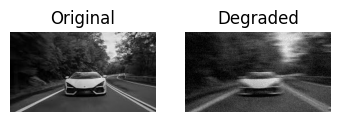

In [ ]:
def degrade_image(image):
    # Apply a motion blur kernel
    kernel_size = 15
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size

    blurred = cv2.filter2D(image, -1, kernel)

    # Add Gaussian noise
    noise = np.random.normal(0, 10, image.shape)
    noisy_blurred = blurred + noise
    noisy_blurred = np.clip(noisy_blurred, 0, 255).astype(np.uint8)

    return noisy_blurred, kernel

degraded_img, psf = degrade_image(img)

plt.subplot(1,3,1), plt.title('Original'), plt.imshow(img, cmap='gray'), plt.axis('off')
plt.subplot(1,3,2), plt.title('Degraded'), plt.imshow(degraded_img, cmap='gray'), plt.axis('off')
plt.show()

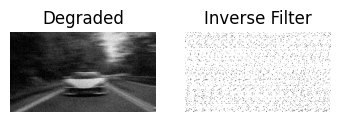

In [ ]:
def inverse_filter(degraded, psf, eps=1e-3):
    # Fourier transform of degraded image
    G = np.fft.fft2(degraded)
    G = np.fft.fftshift(G)

    # Fourier transform of PSF (degradation kernel)
    H = np.fft.fft2(psf, s=degraded.shape)
    H = np.fft.fftshift(H)

    # Avoid division by zero or very small values by adding epsilon
    H_abs = np.abs(H)
    H = np.where(H_abs < eps, eps, H)

    # Inverse filter
    F_hat = G / H

    # Inverse FFT to get restored image
    F_hat = np.fft.ifftshift(F_hat)
    f_hat = np.fft.ifft2(F_hat)
    f_hat = np.abs(f_hat)

    # Normalize and convert to uint8
    f_hat = np.clip(f_hat, 0, 255).astype(np.uint8)
    return f_hat

restored_inverse = inverse_filter(degraded_img, psf)

plt.subplot(1,3,1), plt.title('Degraded'), plt.imshow(degraded_img, cmap='gray'), plt.axis('off')
plt.subplot(1,3,2), plt.title('Inverse Filter'), plt.imshow(restored_inverse, cmap='gray'), plt.axis('off')
plt.show()

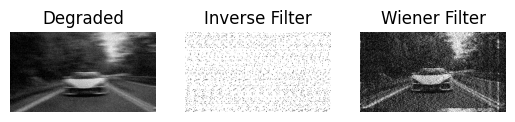

In [ ]:
def wiener_filter(degraded, psf, K=0.01):
    G = np.fft.fft2(degraded)
    G = np.fft.fftshift(G)

    H = np.fft.fft2(psf, s=degraded.shape)
    H = np.fft.fftshift(H)

    H_conj = np.conj(H)
    H_abs2 = np.abs(H)**2

    # Wiener filter formula
    F_hat = (H_conj / (H_abs2 + K)) * G

    F_hat = np.fft.ifftshift(F_hat)
    f_hat = np.fft.ifft2(F_hat)
    f_hat = np.abs(f_hat)

    f_hat = np.clip(f_hat, 0, 255).astype(np.uint8)
    return f_hat

restored_wiener = wiener_filter(degraded_img, psf)

plt.subplot(1,3,1), plt.title('Degraded'), plt.imshow(degraded_img, cmap='gray'), plt.axis('off')
plt.subplot(1,3,2), plt.title('Inverse Filter'), plt.imshow(restored_inverse, cmap='gray'), plt.axis('off')
plt.subplot(1,3,3), plt.title('Wiener Filter'), plt.imshow(restored_wiener, cmap='gray'), plt.axis('off')
plt.show()